# Модульный контроль №1
### Михайловской Валерии

In [385]:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt

### 1. Объедините информацию о пользователях в одной датафрейм

In [386]:
df_metrics_de = pd.read_csv('metrics_de.csv')

df_metrics_ru = pd.read_csv('metrics_ru.csv')
onboarding = pd.read_csv('onboarding.csv')

data = pd.concat([df_metrics_de, df_metrics_ru], ignore_index=True, sort=False)
data = onboarding.merge(data, on='AccountID', how='inner')
data.to_csv('all_data.csv')
data

# result = result.dropna(subset=["Answers"])

,Unnamed: 0_x,AccountID,Answers,AccountOccupationID,AccountOccupationText,AccountSystemEmailsUnsubscribe,AccountConfCrmOnCreation,AccountHadPartner,AccountWorkspaceColorType,AccountIsLiveOn10Day,...,GoogleContacts,ScheduledReport,TaskObject,Lang_Pl,Integration_Avito,Integration_Twilio,Lang_De,DadataIntegration,EmailLastActions,WorkSpaceColor
0,0,310340,"{""whoAmI"": ""Не хочу отвечать"", ""howMany"": ""1"",...",-35.0,Некоммерческая деятельность / Некоммерческая д...,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,310342,"{""whoAmI"": ""Руководитель отдела / команды"", ""h...",-70.0,Торговля / Онлайн-магазин,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,310344,"{""whoAmI"": ""Владелец бизнеса"", ""howMany"": ""2-5...",-124.0,Юридические услуги / Юридические услуги,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,310346,"{""whoAmI"": ""Не хочу отвечать"", ""howMany"": ""51-...",-1.0,IT / IT,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,310350,"{""whoAmI"": ""Работает самостоятельно"", ""howMany...",-1.0,IT / IT,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7552,7745,331476,"{""whoAmI"": ""Директор / топ-менеджер"", ""howMany...",-41.0,Образование и спорт / Образование и спорт,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7553,7749,331484,"{""whoAmI"": ""Работает самостоятельно"", ""howMany...",-10.0,IT / Web-разработка,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7554,7751,331490,"{""whoAmI"": ""Не хочу отвечать"", ""howMany"": ""51-...",-2.0,Агентство / Агентство,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7555,7754,331496,"{""whoAmI"": ""Не хочу отвечать"", ""howMany"": ""51-...",NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Информация о каком количестве пользователей представлена в данных? Какое количество видов деятельности? Постройте барплот по суммарному количеству пользователей по видам деятельности

In [387]:
onboarding_count = onboarding['AccountID'].nunique()
print('Количество пользователей в данных по онбордингу: ' + str(onboarding_count))

metrics_count = df_metrics_de['AccountID'].nunique() + df_metrics_ru['AccountID'].nunique()
print('Количество пользователей в данных метриках: ' + str(metrics_count))


Количество пользователей в данных по онбордингу: 8570
Количество пользователей в данных метриках: 9805


In [388]:
count_of_occupation = data.dropna(subset=['AccountOccupationText'])['AccountOccupationText'].nunique()
print("Количество видов детельности: " + str(count_of_occupation))

Количество видов детельности: 104


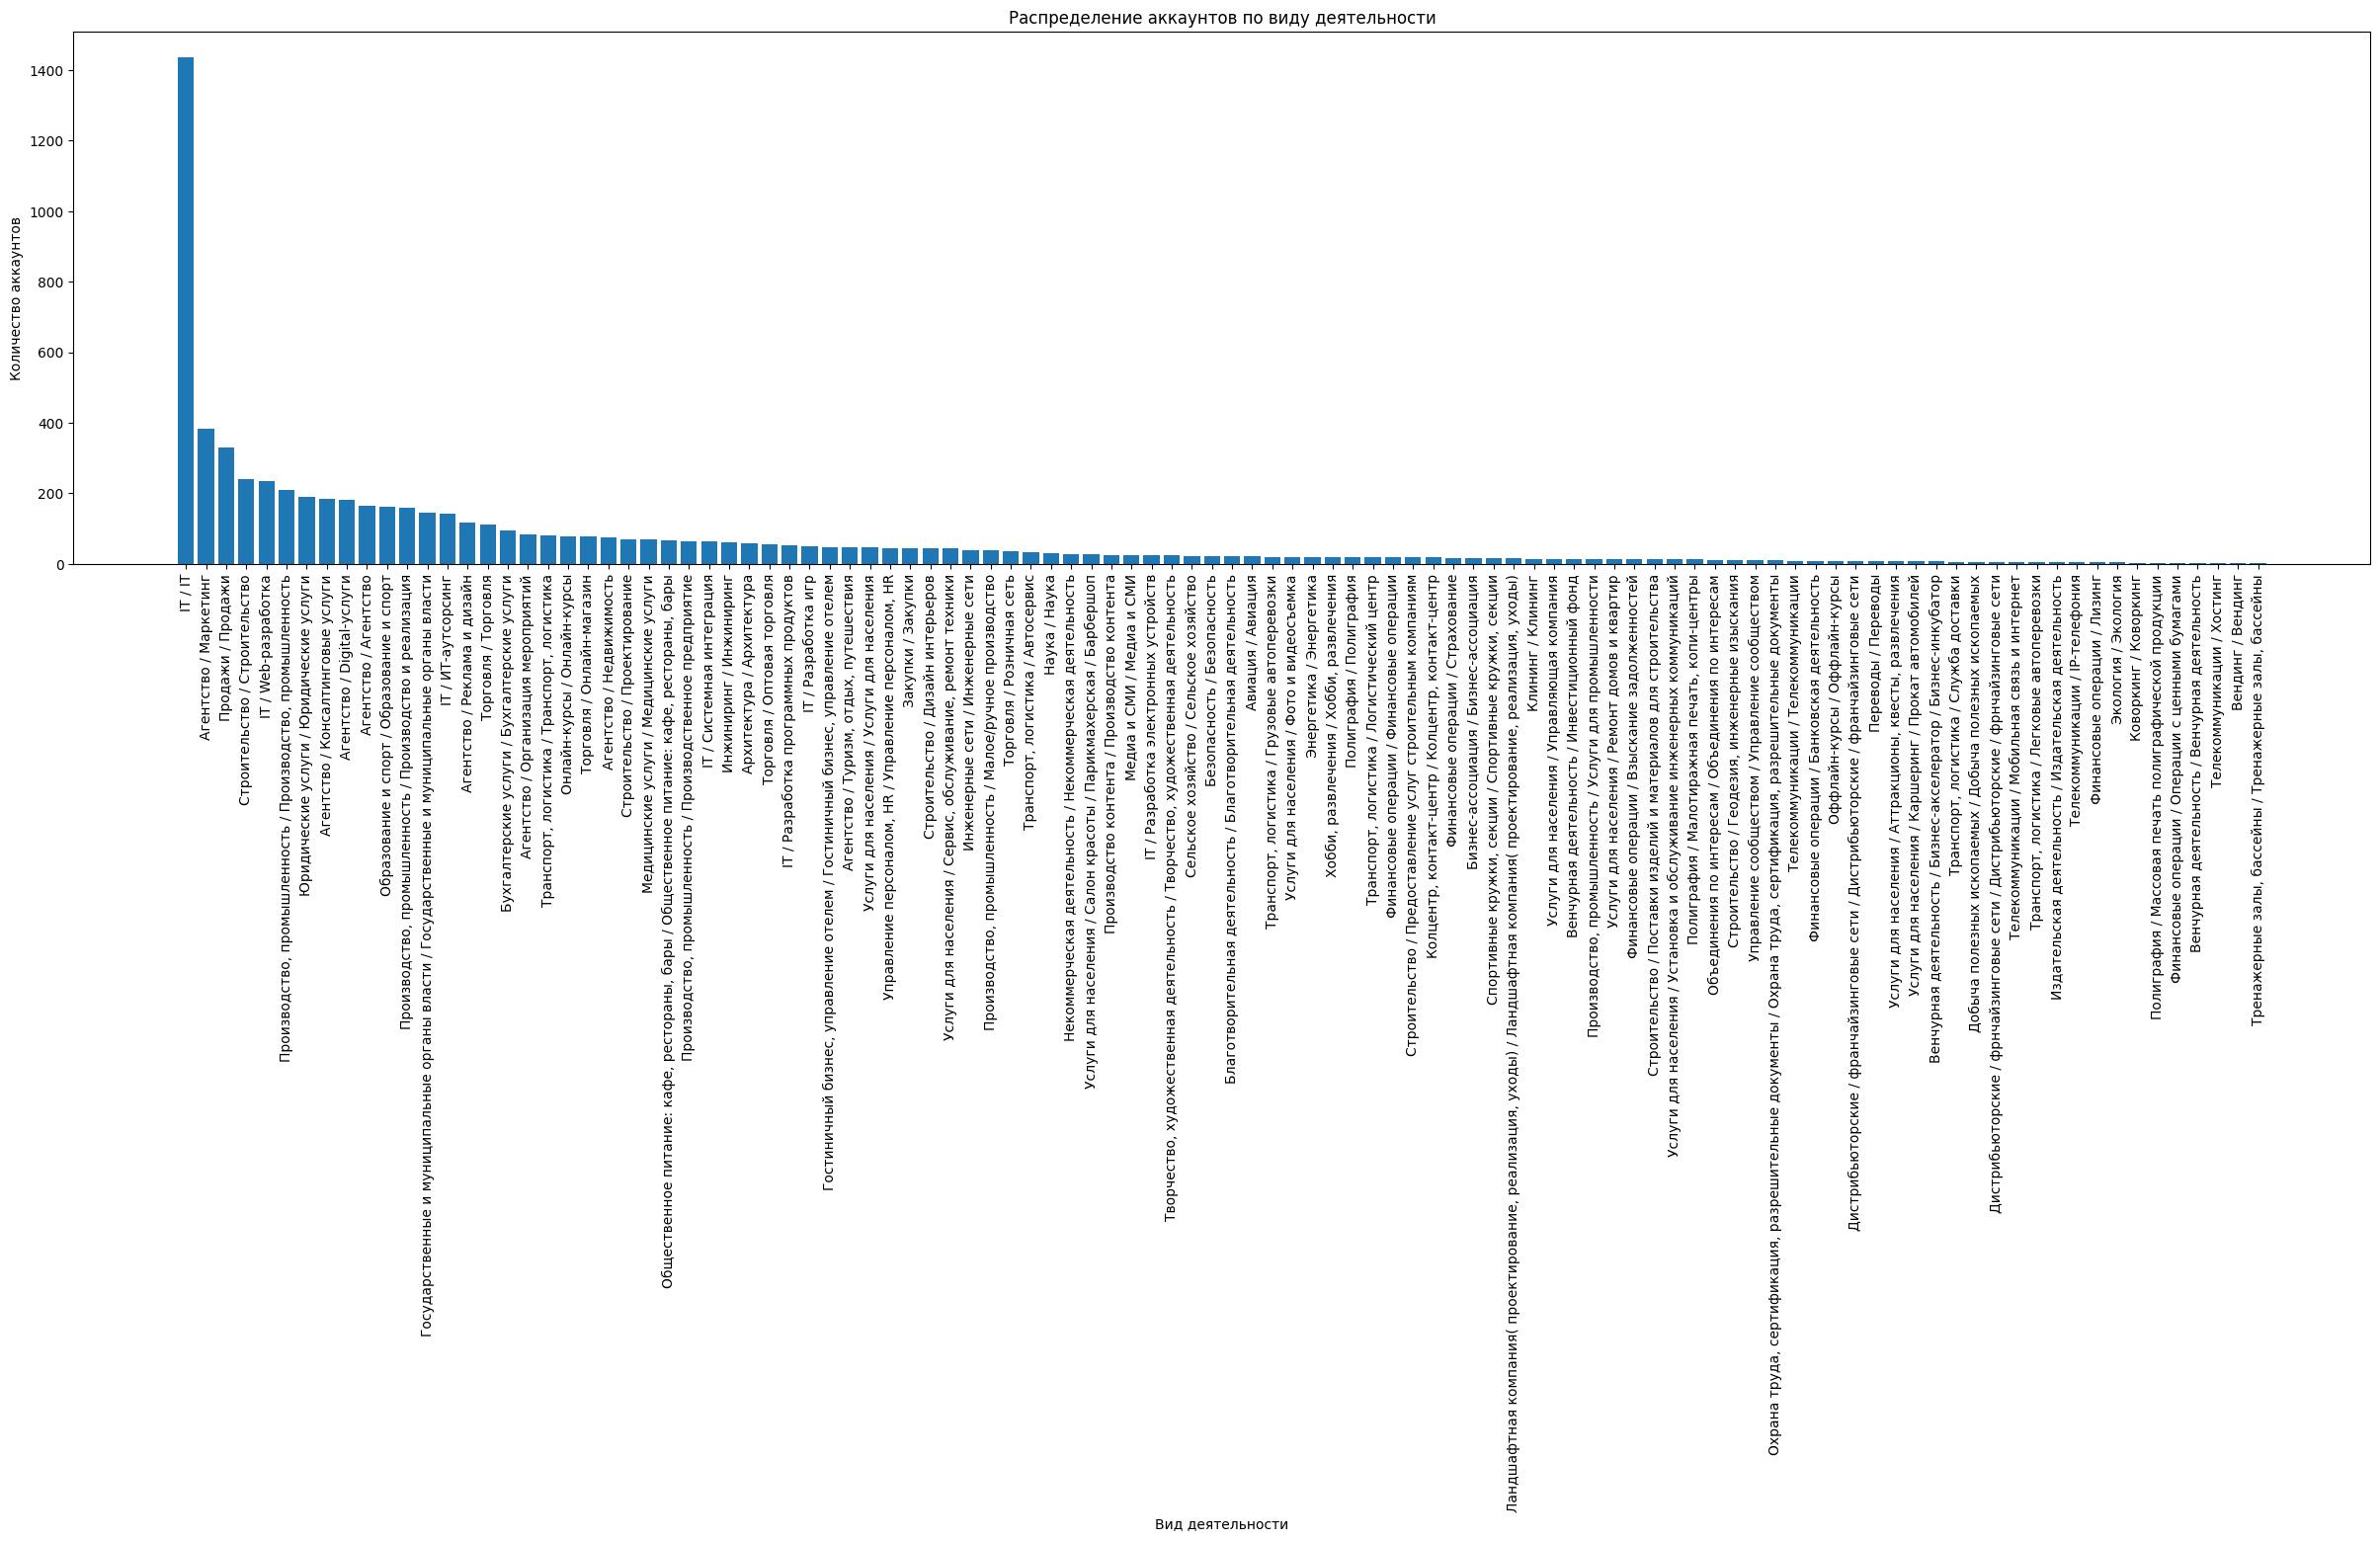

In [389]:
data.groupby('AccountOccupationText')['AccountID'].count()
# data['AccountOccupationText'].isnull().count()
pd.DataFrame([['Не указано', data.isna()['AccountOccupationText'].sum()]], columns=['AccountOccupationText', 'AccountID'])

#data.isna()['AccountOccupationText'].sum()
# count_of_occupations = pd.concat([data.groupby('AccountOccupationText')['AccountID'].count(), pd.Series(data = {'AccountOccupationText': 'Не указано', 'AccountID': data.isna()['AccountOccupationText'].sum()}, index=['AccountOccupationText', 'AccountID'])])


#data.groupby('AccountOccupationText')['AccountID'].count()
grouped = data.groupby('AccountOccupationText').agg({
    'AccountID': 'count'
})
grouped = grouped.sort_values(['AccountID'], ascending=False)

plt.figure(figsize=(30, 7))
#data.groupby('AccountOccupationText')['AccountID'].count().plot(kind="bar")
plt.bar(list(grouped.index), list(np.squeeze(grouped.values)))
plt.xticks(rotation=90)
plt.xlabel('Вид деятельности')
plt.ylabel('Количество аккаунтов')
plt.title('Распределение аккаунтов по виду деятельности')
plt.show()

### 3. Создайте новые столбцы, содержащие информацию об ответах на вопросы

In [390]:
# data['Answers'] = data['Answers'].apply(json.loads)
# data = pd.concat([data.drop(['Answers'], axis=1), data['Answers'].apply(pd.Series)], axis=1)
#data['whoAmI']

### 4. Создайте новые столбцы, содержащие данные об accountparams и accountregistration

In [391]:
# print(data['AccountParams'])
# data['AccountParams'] = data['AccountParams'].apply(json.loads)
# data= pd.concat([data.drop(['AccountParams'], axis=1), data['AccountParams'].apply(pd.Series)], axis=1)
# data['gaClientId']

import math

def is_nan(item):
    if type(item) == 'float':
        if np.isnan(item):
            return True
    return False

json_columns = ['AccountParams', 'Answers', 'AccountRegistrationGAFullData', 'AccountRegistrationGAData']
# for column in json_columns:
#     data[column] = data[column].apply(json.loads)
#     data= pd.concat([data.drop([column], axis=1), data[column].apply(pd.Series)], axis=1)

# print(data['AccountParams'][0])
# print(data['Answers'][0])
# data['gaClientId']
# a = json.loads(data['AccountParams'][0])
# a
# column = 'AccountRegistrationGAFullData'
# data['AccountRegistrationGAFullData'] = data['AccountRegistrationGAFullData'].apply(json.loads)
# data= pd.concat([data.drop(['AccountRegistrationGAFullData'], axis=1), data['AccountRegistrationGAFullData'].apply(pd.Series)], axis=1)

# data['AccountRegistrationGAFullData'] = data['AccountRegistrationGAFullData'].astype('str')



data['AccountRegistrationGAFullData'] = data['AccountRegistrationGAFullData'].apply(lambda x: json.loads(x) if not(is_nan(x)) else x)
# data= pd.concat([data.drop(['AccountRegistrationGAFullData'], axis=1), data['AccountRegistrationGAFullData'].apply(lambda x: pd.Series(eval(x)) if not(is_nan(x)) else x)], axis=1)



# pd.Series(eval(data['AccountRegistrationGAFullData'][0]))

# data['platform']
# data.to_csv('te.csv')
# 

# for i in data['AccountRegistrationGAFullData']:
#     if not(is_nan(i)):
#         data['AccountRegistrationGAFullData'][i] = json.loads(i)


# data['AccountRegistrationGAFullData'][2]

# data['AccountRegistrationGAFullData'] = data['AccountRegistrationGAFullData'].apply(lambda x: json.loads(x) if not(is_nan(x)) else x)

TypeError: the JSON object must be str, bytes or bytearray, not float

In [28]:
test = pd.DataFrame([['2', '3', '4']], columns=['A', 'B', 'C'])
cn = pd.DataFrame([['4', '5', '6']], columns=['A', 'C', 'L'])

main = pd.DataFrame([['2', '5'],['4', '7'], ['6', '9']], columns=['A', 'K'])

r = pd.concat([test, cn], ignore_index=True, sort=False)
r
res = main.merge(r, on='A', how='left')
# res

,A,B,C,L
0,2,3,4,NaN
1,4,NaN,5,6
